This notebook is my simulations for the submitted Globecom Paper. The title of the paper is:

**Federated Learning for Cellular-connected UAVs: Radio Mapping and Path Planning**

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim


import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [0]:
# random point generator inside a square. The length is d, the left down corner is given by corner. 
def Points_generator(corner, d, N_points):
  Points = np.zeros((N_points,2)) 
  for n in range(N_points):
    x = corner[0] + d*random.random()
    y = corner[0] + d*random.random()
    Points[n,0] = x
    Points[n,1] = y

  return Points

# data generator:
def data_generator(n_samples,thr ):
  P = 0.2 # GBS transmit power
  ## Location of the GBSs:
  x = [5, 6.8, 6.4, 5, 3.2, 1.5, 3.4, 3.2, 2, 1, 1.7, 3.6, 6, 5.3, 7, 8.4, 8, 7.5]
  y = [5, 5, 6.7, 8, 7.8, 7.5, 5.7, 4.5, 5, 3.4, 2,2, 3.4, 1.6, 1, 5, 3.2, 7.5]
  BS = {}
  Points = Points_generator([0,0], 10, n_samples)
  rss = {}
  for b in range(len(x)):
    BS[b] = np.zeros((2))
    BS[b][0] = x[b]
    BS[b][1] = y[b]
    rss[b] = np.zeros(n_samples)
  
  RSS =np.zeros(n_samples)
  for n in range(n_samples):
    for b in BS.keys():
      #Since the altitude of the UAV is 100m, we use 0.1km so 0.1*0.1 = 0.01 
      distance = (np.linalg.norm(Points[n,:]-BS[b]))**2 + 0.01
      rss[b][n] = np.divide(P*random.random(), (84*84*1000*1000*distance) )
    temp_var = np.sum([rss[b][n] for b in BS.keys()])
    RSS[n] = max([ rss[b][n]/(temp_var - rss[b][n]+ 10**(-14)) for b in BS.keys()  ])
  RSS = np.float32(RSS)
  RSS_target = np.copy(RSS)
  for r in range(n_samples):
    if RSS[r] > thr:
      RSS_target[r] = 1
    else:
      RSS_target[r] = 0 
  #print(RSS)
  RSS_target = RSS_target.astype(int)
  RSS_target = torch.tensor(RSS_target)
  RSS_target = RSS_target#.view(-1, 1)


  Points = np.float32(Points)
  Points = torch.tensor(Points)
  
  return Points, RSS_target

**Neural Network:**

Now, we define the Neural Network.

In [0]:
class DNN(nn.Module):
    def __init__(self, n_hidden):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(2, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        #self.fc4 = nn.Linear(n_hidden, n_hidden)
        self.fc5 = nn.Linear(n_hidden, 2)
        #self.fc2 = nn.Linear(n_hidden, n_hidden)
        #self.h_pi = nn.Linear(n_hidden, n_gaussians)
        #self.h_mu = nn.Linear(n_hidden, n_gaussians)
        #self.h_sigma = nn.Linear(n_hidden, n_gaussians)
        
    def forward(self, x):
        z = F.relu(self.fc1(x))
        z = F.relu(self.fc2(z))
        z = F.relu(self.fc3(z))
        #z = torch.tanh(self.fc4(z))
        #output= F.dropout(z, p = .4 , training = True)
        output = F.softmax(self.fc5(z))
        return output

In [0]:
def worker_update(worker_model, optimizer, Points, RSS_targets, epoch):
  running_loss = 0
  for e in range(epoch):
    optimizer.zero_grad()
    outputs = worker_model(Points)
    loss = criterion(outputs, RSS_target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  return running_loss


def server_aggregate(global_model, worker_models):
  global_dict = global_model.state_dict()
  for k in global_dict.keys():
    global_dict[k] = torch.stack([worker_models[i].state_dict()[k] for i in range(len(worker_models))], 0).mean(0)
  global_model.load_state_dict(global_dict)
  for model in worker_models:
    model.load_state_dict(global_model.state_dict())

In [0]:
num_workers = 10

global_model = DNN(n_hidden = 256)
worker_models = [DNN(n_hidden = 256) for _ in range(num_workers)]
for model in worker_models:
    model.load_state_dict(global_model.state_dict())

criterion = nn.CrossEntropyLoss()
optimizer = [optim.Adam(model.parameters()) for model in worker_models]



In [0]:
num_rounds = 200
epochs = 10
n_samples = 1000
thr = .65
Avg_Loss_rounds = np.zeros(num_rounds) 
loss = np.zeros(num_workers)
loss_rounds = np.zeros((num_rounds,num_workers))
Points, RSS_target = data_generator(n_samples,thr )
Data = {}
for w in range(num_workers):
  Data[w]={}
  Data[w]['Points'] = Points 
  Data[w]['RSS_target'] = RSS_target

for r in range(num_rounds):
  for w in range(num_workers):
    Points, RSS_target = data_generator(n_samples,thr )
    Data[w]['Points'] = Points 
    Data[w]['RSS_target'] = RSS_target
    loss[w] += worker_update(worker_models[w], optimizer[w], Data[w]['Points'], Data[w]['RSS_target'], epoch=epochs)
    # select random clients
    #client_idx = np.random.permutation(num_clients)[:num_selected]

    loss_rounds[r,w] = np.copy(loss[w])#/((r+1)*epochs)
    # client update

    
    # server aggregate
  server_aggregate(global_model, worker_models)
  Avg_Loss_rounds[r] = (np.mean(loss_rounds[r,:]))/((r+1)*epochs)
  if r%10 == 0:
    print('round number {0}'.format(r))
    #print('round: {0}, loss1 = {1}, loss2 = {2}'.format(r,loss[0]/((r+1)*epochs), loss[1]/((r+1)*epochs)))
#plt.figure()
#plt.plot(range(num_rounds),Avg_Loss_rounds, c = 'red')
#plt.show()
#print(Avg_Loss_rounds[-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: ignored

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


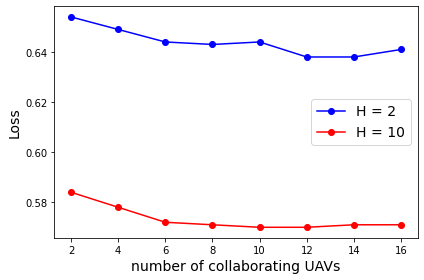

In [0]:
plt.figure(tight_layout=True)
L_part2_10 = [0.584, 0.578, 0.572, 0.571, 0.570, 0.570,0.571,0.571]
L_part2_2 = [0.654, 0.649, 0.644, 0.643, 0.644,0.638, 0.638,0.641]
n_Workers = [2, 4, 6, 8, 10, 12, 14, 16]
plt.plot(n_Workers, L_part2_2, c ='blue', marker = 'o', label ='H = 2')
plt.plot(n_Workers, L_part2_10, c ='red', marker = 'o', label ='H = 10')
plt.legend(loc='best',fontsize = 14)
plt.xlabel('number of collaborating UAVs', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
#plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('L2.eps',format = 'eps')
plt.show()



In [0]:
##Epoch =2
L2 = Avg_Loss_rounds

In [0]:
L10 = Avg_Loss_rounds

In [0]:
L30 = Avg_Loss_rounds

In [0]:
L100 = Avg_Loss_rounds

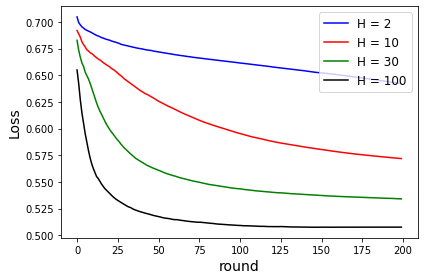

In [0]:
plt.figure(tight_layout=True)
plt.plot(range(num_rounds), L2 , c = 'blue', label='H = 2')
plt.plot(range(num_rounds), L10 , c = 'red', label='H = 10')
plt.plot(range(num_rounds), L30 , c = 'green', label='H = 30')
plt.plot(range(num_rounds), L100 , c = 'k', label='H = 100')
plt.legend(loc = 1, fontsize = 12)
#plt.grid(color='k', ls = '-.')
#plt.grid(True)
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('round', fontsize = 14)
#plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('L1.pdf',format = 'pdf')
plt.show()

In [0]:
import dill                            #pip install dill --user
filename = 'globalsave.pkl'
dill.dump_session(filename)

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Based on the output of the trained neural network, we can obtain the outage probability in each point of the environment. the coordinates of these points are (x,y,H)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


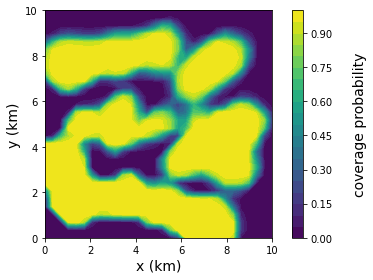

In [0]:
M=30
x = np.linspace(0,10,M)
y = np.linspace(0,10,M)
#X,Y = np.meshgrid(x,y)
probb = np.zeros((M,M))
#model.eval()

with torch.no_grad():
  for ii in range(M):
    for jj in range(M):
      a = np.float32([ x[ii], y[jj] ])#.tolist()    
      probb[ii,jj] = global_model(torch.tensor(a))[0]



#plt.figure()
plt.figure(tight_layout=True)
#plt.style.use('classic')
probb = probb.T
plt.contourf(x,y,1- probb, 20)
v = np.linspace(0, 1.0, 11, endpoint=True)
cbar=plt.colorbar()
cbar.set_label('coverage probability',labelpad=20, rotation=90,fontsize=14) 
plt.xlabel('x (km)',fontsize=14)
plt.ylabel('y (km)',fontsize=14)

#x = [5, 6.8, 6.4, 5, 3.2, 1.5, 3.4, 3.2, 2, 1, 1.7, 3.6, 6, 5.3, 7, 8.4, 8, 7.5]
#y = [5, 5, 6.7, 8, 7.8, 7.5, 5.7, 4.5, 5, 3.4, 2,2, 3.4, 1.6, 1, 5, 3.2, 7.5]
#plt.scatter(x,y, marker = "^", s = 20, c = 'k', alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('Outage.eps',format = 'eps')
plt.show()


Now, we draw the location of the GBSs to be able to assess the quality of our trained model:


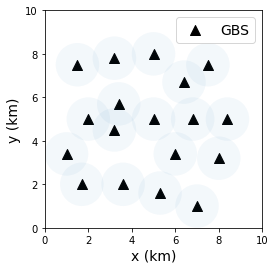

In [0]:
fig, ax = plt.subplots()
x = [5, 6.8, 6.4, 5, 3.2, 1.5, 3.4, 3.2, 2, 1, 1.7, 3.6, 6, 5.3, 7, 8.4, 8, 7.5]
y = [5, 5, 6.7, 8, 7.8, 7.5, 5.7, 4.5, 5, 3.4, 2,2, 3.4, 1.6, 1, 5, 3.2, 7.5]
for i in range(len(x)):
  ax.add_patch(plt.Circle((x[i], y[i]), 1, alpha=0.05))

plt.scatter(x,y, marker = "^", s = 100, c = 'k', alpha=1, label = 'GBS')
plt.xlabel('x (km)',fontsize=14)
plt.xlim(0,10)
plt.ylabel('y (km)',fontsize=14)
plt.ylim(0,10)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(False)
plt.legend(fontsize=14)
plt.savefig('GBS.pdf',format = 'pdf')
ax.plot()   #Causes an autoscale update.
plt.show()

In [0]:
# One snap-shot of the radiations:

M = 50
x = np.linspace(0,10,M)
y = np.linspace(0,10,M)
#print(x)
#X,Y = np.meshgrid(x,y)
val = np.zeros((M,M))
for ii in range(M):
  for jj in range(M):
    val[ii,jj] = Gain([ x[ii], y[jj] ])
plt.figure()
plt.contourf(x,y, val.T)
v = np.linspace(0, 100, 5, endpoint=True)
cbar=plt.colorbar(ticks=v, )
cbar.set_label('Received Power',labelpad=20, rotation=270,fontsize=14)
#plt.scatter(Data[:,0], Data[:,1],RSS)
#plt.scatter(x,y, c = 'red')
plt.gca().set_aspect('equal', adjustable='box')
x = [5, 6.8, 6.4, 5, 3.2, 1.5, 3.4, 3.2, 2, 1, 1.7, 3.6, 6, 5.3, 7, 8.4, 8, 7.5]
y = [5, 5, 6.7, 8, 7.8, 7.5, 5.7, 4.5, 5, 3.4, 2,2, 3.4, 1.6, 1, 5, 3.2, 7.5]
plt.scatter(x,y)
plt.show()
#print(val[20,:])

In [0]:
def Gain(Points):
  n_samples = 1
  P = 0.2
  x = [5, 6.8, 6.4, 5, 3.2, 1.5, 3.4, 3.2, 2, 1, 1.7, 3.6, 6, 5.3, 7, 8.4, 8, 7.5]
  y = [5, 5, 6.7, 8, 7.8, 7.5, 5.7, 4.5, 5, 3.4, 2,2, 3.4, 1.6, 1, 5, 3.2, 7.5]
  BS = {}
  rss = {}
  for b in range(len(x)):
    BS[b] = np.zeros((2))
    BS[b][0] = x[b]
    BS[b][1] = y[b]
    rss[b] = np.zeros(n_samples)
  
  RSS =np.zeros((n_samples,1))
  for n in range(n_samples):
    for b in BS.keys():
      distance = (np.linalg.norm(Points-BS[b]))**2 + 0.01
      rss[b][n] = np.divide(P*random.random(), (84*84*1000*1000*distance) )
    temp_var = np.sum([rss[b][n] for b in BS.keys()])
    RSS[n] = max([ rss[b][n]/(temp_var - rss[b][n] +10**(-14) ) for b in BS.keys()  ])

  RSS = np.float32(RSS)
  RSS = torch.tensor(RSS)  
  return RSS

**************************************

Now, after this training, we can use RRT* to design the trajectory of the UAVs. 

In [0]:
class Node:
  def __init__(self, coord, parent, cost):
    
    self.coord = coord
    self.parent = parent
    self.cost = cost

class RRT:
  def __init__(self,model):
    self.model = model
    self.nodes = {}
    self.q_start = Node([9, 5],0,0)
    self.q_goal = Node([8.5,8], None, 0)


  def steer(self,qr, qn, val, eps):
    qnew = [0,0]
    if val >= eps:
      dist = np.linalg.norm (np.subtract(qr,qn))
      qnew[0] = qn[0] + ((qr[0] - qn[0])*eps)/dist
      qnew[1] = qn[1] + ((qr[1] - qn[1])*eps)/dist
    else:
      qnew[0] = qr[0]
      qnew[1] = qr[1]
    return [qnew[0],qnew[1]]




  def constraints(self,n2,n1):
    # if satisfied return True
    a = np.float32(n2)
    b = np.float32(n1)
    #a = np.float32([ x[ii], y[jj] ])#.tolist()    
    prob_1= self.model(torch.tensor(a))[1]
    prob_2= self.model(torch.tensor(b))[1]
    if prob_1 > 0.5 and prob_2 >0.5:
      return True
    else:
      return False


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


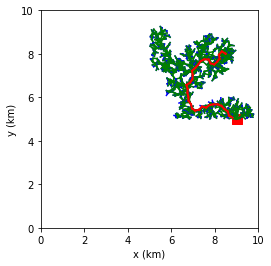

In [0]:
num_Nodes = 3000
x_max = 5
y_max = 5
#EPS = 0.05
EPS = 0.1
r=0.2

rrt = RRT(model)
rrt.nodes[0] = rrt.q_start
plt.figure()
for n in range(num_Nodes):
  q_rand = [5 + random.random()*x_max, 5 + random.random()*y_max ]
  #plt.scatter(q_rand[0],q_rand[1], c = 'k', s = 10)
  for j in range(len(rrt.nodes.keys())):
    if np.linalg.norm( np.subtract(rrt.nodes[j].coord,rrt.q_goal.coord) ) < 0.5:
      break
  
  ndist = []
  for j in range(len(rrt.nodes.keys())):
    n = rrt.nodes[j];
    tmp = np.linalg.norm( np.subtract(n.coord, q_rand) );
    ndist.append(tmp)
  val = np.min(ndist)
  idx = np.argmin(ndist)
  q_near = rrt.nodes[idx]
  q_new = Node(None, None, None)
  q_new.coord = rrt.steer(q_rand, q_near.coord, val, EPS);
  if rrt.constraints(q_rand, q_near.coord):
    plt.plot([q_near.coord[0], q_new.coord[0]], [q_near.coord[1], q_new.coord[1]], c = 'b' )
    q_new.cost = np.linalg.norm(np.subtract(q_new.coord , q_near.coord)) + q_near.cost;


    q_nearest = {}
    
    neighbor_count = 0
    for j in range(len(rrt.nodes.keys())):
      if rrt.constraints( rrt.nodes[j].coord , q_new.coord ) and np.linalg.norm( np.subtract( rrt.nodes[j].coord , q_new.coord )) <= r:
        q_nearest[neighbor_count] = Node(None, None, None)
        q_nearest[neighbor_count].coord = rrt.nodes[j].coord
        q_nearest[neighbor_count].cost = rrt.nodes[j].cost
        neighbor_count +=1

    q_min = q_near
    C_min = q_new.cost
    #print(q_nearest[0].cost)
    for k in range(len(q_nearest.keys())):
      if rrt.constraints(q_nearest[k].coord, q_new.coord) and (q_nearest[k].cost + np.linalg.norm( np.subtract(q_nearest[k].coord,q_new.coord)) < C_min):
        q_min = q_nearest[k]
        C_min = q_nearest[k].cost + np.linalg.norm( np.subtract( q_nearest[k].coord, q_new.coord ) ) 
        plt.plot([q_min.coord[0], q_new.coord[0]], [q_min.coord[1], q_new.coord[1]], c = 'g')

    for j in range(len(rrt.nodes.keys())):
      if rrt.nodes[j].coord[0] == q_min.coord[0] and rrt.nodes[j].coord[1] == q_min.coord[1]:
        q_new.parent = j
    
    l = len(rrt.nodes.keys())
    rrt.nodes[l] = q_new


D = []
for j in range(len(rrt.nodes.keys())):
    tmpdist = np.linalg.norm(np.subtract(rrt.nodes[j].coord, rrt.q_goal.coord ) ) 
    D.append(tmpdist)

#search backward
val = np.min(D)
idx = np.argmin(D)

q_final = rrt.nodes[idx]
rrt.q_goal.parent = idx
q_end = rrt.q_goal
l = len(rrt.nodes.keys())
rrt.nodes[l] = rrt.q_goal
while q_end.parent != 0:
  start = q_end.parent
  plt.plot([q_end.coord[0], rrt.nodes[start].coord[0]] , [q_end.coord[1], rrt.nodes[start].coord[1]] , c = 'r',linewidth=2 )

  q_end = rrt.nodes[start]



plt.scatter(rrt.q_start.coord[0],rrt.q_start.coord[1], marker = 's', s=100, c = 'red')
plt.scatter(rrt.q_goal.coord[0],rrt.q_goal.coord[1], marker = 's', s=100, c = 'g')
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('Expansion.pdf',format = 'pdf')
plt.show()

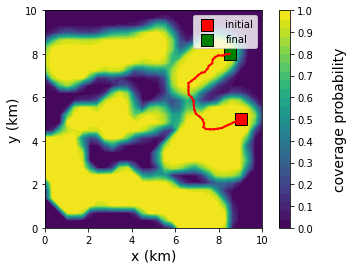

In [0]:
M=30
x = np.linspace(0,10,M)
y = np.linspace(0,10,M)

#PROB = 0.5*(P1+P2) 
PROB = probb
plt.contourf(x,y,1 - PROB, 30)
v = np.linspace(0, 1.0, 11, endpoint=True)
cbar=plt.colorbar(ticks=v)
cbar.set_label('coverage probability',labelpad=20, rotation=90,fontsize=14) 
plt.xlabel('x (km)',fontsize=14)
plt.ylabel('y (km)',fontsize=14)

#x = [5, 6.8, 6.4, 5, 3.2, 1.5, 3.4, 3.2, 2, 1, 1.7, 3.6, 6, 5.3, 7, 8.4, 8, 7.5]
#y = [5, 5, 6.7, 8, 7.8, 7.5, 5.7, 4.5, 5, 3.4, 2,2, 3.4, 1.6, 1, 5, 3.2, 7.5]
#plt.scatter(x,y)
plt.gca().set_aspect('equal', adjustable='box')

#search backward
val = np.min(D)
idx = np.argmin(D)
#rrt.q_goal.coord = [9,8]
q_final = rrt.nodes[idx]
rrt.q_goal.parent = idx
q_end = rrt.q_goal
l = len(rrt.nodes.keys())
rrt.nodes[l] = rrt.q_goal
while q_end.parent != 0:
  start = q_end.parent
  plt.plot([q_end.coord[0], rrt.nodes[start].coord[0]] , [q_end.coord[1], rrt.nodes[start].coord[1]] , c = 'r',linewidth=2, )

  q_end = rrt.nodes[start]



plt.scatter(rrt.q_start.coord[0],rrt.q_start.coord[1], marker = 's',ec = 'k', s=140, c = 'red', label = 'initial')
plt.scatter(rrt.q_goal.coord[0],rrt.q_goal.coord[1], marker = 's', ec = 'k',  s=140, c = 'g', label ='final')
plt.xlim(0,10)
plt.ylim(0,10)
plt.legend(loc ='best')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('T2.pdf',format = 'pdf')
plt.show()

In [0]:
D_1 = D
rrt_1 = rrt

In [0]:
D_2 = D
rrt_2 = rrt

In [0]:
D_3 = D
rrt_3 = rrt

In [0]:
D_4 = D
rrt_4 = rrt

In [0]:
M=30
x = np.linspace(0,10,M)
y = np.linspace(0,10,M)

#PROB = 0.5*(P1+P2) 
PROB = probb
plt.contourf(x,y,1 - PROB, 30)
v = np.linspace(0, 1.0, 11, endpoint=True)
cbar=plt.colorbar(ticks=v)
cbar.set_label('coverage probability',labelpad=20, rotation=270,fontsize=14) 
plt.xlabel('x (meter)',fontsize=14)
plt.ylabel('y (meter)',fontsize=14)

x = [5, 6.8, 6.4, 5, 3.2, 1.5, 3.4, 3.2, 2, 1, 1.7, 3.6, 6, 5.3, 7, 8.4, 8, 7.5]
y = [5, 5, 6.7, 8, 7.8, 7.5, 5.7, 4.5, 5, 3.4, 2,2, 3.4, 1.6, 1, 5, 3.2, 7.5]
plt.scatter(x,y)
plt.gca().set_aspect('equal', adjustable='box')

#search backward
val = np.min(D_1)
idx = np.argmin(D_1)
q_final = rrt_1.nodes[idx]
rrt_1.q_goal.parent = idx
q_end = rrt_1.q_goal
l = len(rrt_1.nodes.keys())
rrt_1.nodes[l] = rrt_1.q_goal
while q_end.parent != 0:
  start = q_end.parent
  plt.plot([q_end.coord[0], rrt_1.nodes[start].coord[0]] , [q_end.coord[1], rrt_1.nodes[start].coord[1]] , c = 'r',linewidth=4 )

  q_end = rrt_1.nodes[start]

plt.scatter(rrt_1.q_start.coord[0],rrt_1.q_start.coord[1], marker = 's', s=100, c = 'red', label = 'initial')
plt.scatter(rrt_1.q_goal.coord[0],rrt_1.q_goal.coord[1], marker = 's', s=100, c = 'g', label = 'final')



#search backward
val = np.min(D_2)
idx = np.argmin(D_2)
q_final = rrt_2.nodes[idx]
rrt_2.q_goal.parent = idx
q_end = rrt_2.q_goal
l = len(rrt_2.nodes.keys())
rrt_2.nodes[l] = rrt_2.q_goal
while q_end.parent != 0:
  start = q_end.parent
  plt.plot([q_end.coord[0], rrt_2.nodes[start].coord[0]] , [q_end.coord[1], rrt_2.nodes[start].coord[1]] , c = 'r',linewidth=4 )

  q_end = rrt_2.nodes[start]

plt.scatter(rrt_2.q_start.coord[0],rrt_2.q_start.coord[1], marker = 's', s=100, c = 'red')
plt.scatter(rrt_2.q_goal.coord[0],rrt_2.q_goal.coord[1], marker = 's', s=100, c = 'g')


#search backward
val = np.min(D_3)
idx = np.argmin(D_3)
q_final = rrt_3.nodes[idx]
rrt_3.q_goal.parent = idx
q_end = rrt_3.q_goal
l = len(rrt_3.nodes.keys())
rrt_3.nodes[l] = rrt_3.q_goal
while q_end.parent != 0:
  start = q_end.parent
  plt.plot([q_end.coord[0], rrt_3.nodes[start].coord[0]] , [q_end.coord[1], rrt_3.nodes[start].coord[1]] , c = 'r',linewidth=4 )

  q_end = rrt_1.nodes[start]

plt.scatter(rrt_3.q_start.coord[0],rrt_3.q_start.coord[1], marker = 's', s=100, c = 'red')
plt.scatter(rrt_3.q_goal.coord[0],rrt_3.q_goal.coord[1], marker = 's', s=100, c = 'g')


#search backward
val = np.min(D_4)
idx = np.argmin(D_4)
q_final = rrt_4.nodes[idx]
rrt_4.q_goal.parent = idx
q_end = rrt_4.q_goal
l = len(rrt_4.nodes.keys())
rrt_4.nodes[l] = rrt_4.q_goal
while q_end.parent != 0:
  start = q_end.parent
  plt.plot([q_end.coord[0], rrt_4.nodes[start].coord[0]] , [q_end.coord[1], rrt_4.nodes[start].coord[1]] , c = 'r',linewidth=4 )

  q_end = rrt_4.nodes[start]

plt.scatter(rrt_4.q_start.coord[0],rrt_4.q_start.coord[1], marker = 's', s=100, c = 'red')
plt.scatter(rrt_4.q_goal.coord[0],rrt_4.q_goal.coord[1], marker = 's', s=100, c = 'g')




plt.xlim(0,10)
plt.ylim(0,10)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


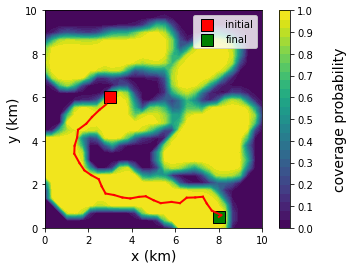

In [0]:
M=30
x = np.linspace(0,10,M)
y = np.linspace(0,10,M)

#PROB = 0.5*(P1+P2) 
PROB = probb
plt.contourf(x,y,1 - PROB, 30)
v = np.linspace(0, 1.0, 11, endpoint=True)
cbar=plt.colorbar(ticks=v)
cbar.set_label('coverage probability',labelpad=20, rotation=90,fontsize=14) 
plt.xlabel('x (km)',fontsize=14)
plt.ylabel('y (km)',fontsize=14)

#x = [5, 6.8, 6.4, 5, 3.2, 1.5, 3.4, 3.2, 2, 1, 1.7, 3.6, 6, 5.3, 7, 8.4, 8, 7.5]
#y = [5, 5, 6.7, 8, 7.8, 7.5, 5.7, 4.5, 5, 3.4, 2,2, 3.4, 1.6, 1, 5, 3.2, 7.5]
#plt.scatter(x,y)
plt.gca().set_aspect('equal', adjustable='box')

#search backward
val = np.min(D_1)
idx = np.argmin(D_1)
q_final = rrt_1.nodes[idx]
rrt_1.q_goal.parent = idx
q_end = rrt_1.q_goal
l = len(rrt_1.nodes.keys())
rrt_1.nodes[l] = rrt_1.q_goal
while q_end.parent != 0:
  start = q_end.parent
  plt.plot([q_end.coord[0], rrt_1.nodes[start].coord[0]] , [q_end.coord[1], rrt_1.nodes[start].coord[1]] , c = 'r',linewidth=2 )

  q_end = rrt_1.nodes[start]
plt.plot([q_end.coord[0], rrt_1.nodes[start].coord[0]] , [q_end.coord[1], rrt_1.nodes[start].coord[1]] , c = 'r',linewidth=2 )

plt.scatter(rrt_1.q_start.coord[0],rrt_1.q_start.coord[1], marker = 's',ec = 'k',  s=140, c = 'red', label = 'initial')
plt.scatter(rrt_1.q_goal.coord[0],rrt_1.q_goal.coord[1], marker = 's',ec = 'k', s=140, c = 'g', label = 'final')



plt.legend(loc='best')
plt.xlim(0,10)
plt.ylim(0,10)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('T2.eps',format = 'eps')
plt.show()

In [0]:
rrt_1.q_goal.coord

[8, 0.5]

In [0]:
import dill                            #pip install dill --user
filename = 'globalsave.pkl'
# and to load the session again:
dill.load_session(filename)